Gabriel Riegner: 14 FEB 2024  

##### Homework Assignment 4

---

##### 1. Power Law

(a) Introducing click counts will likely incline people to select links with already high view counts, because people tend to copy the decisions of others who act before them. This is an example of the "rich-get-richer" phenomenon.

(b) The addition of view counters would likely cause the popularity distribution to follow a power law more closely. Power laws arise from feedback introduced by correlated decisions across a population, eventually creating a degree distribution with many items with few links and a few items with many links.

##### 2. Graph visualization - Cora

Scientific publications:	2708
Citation network links:		5429


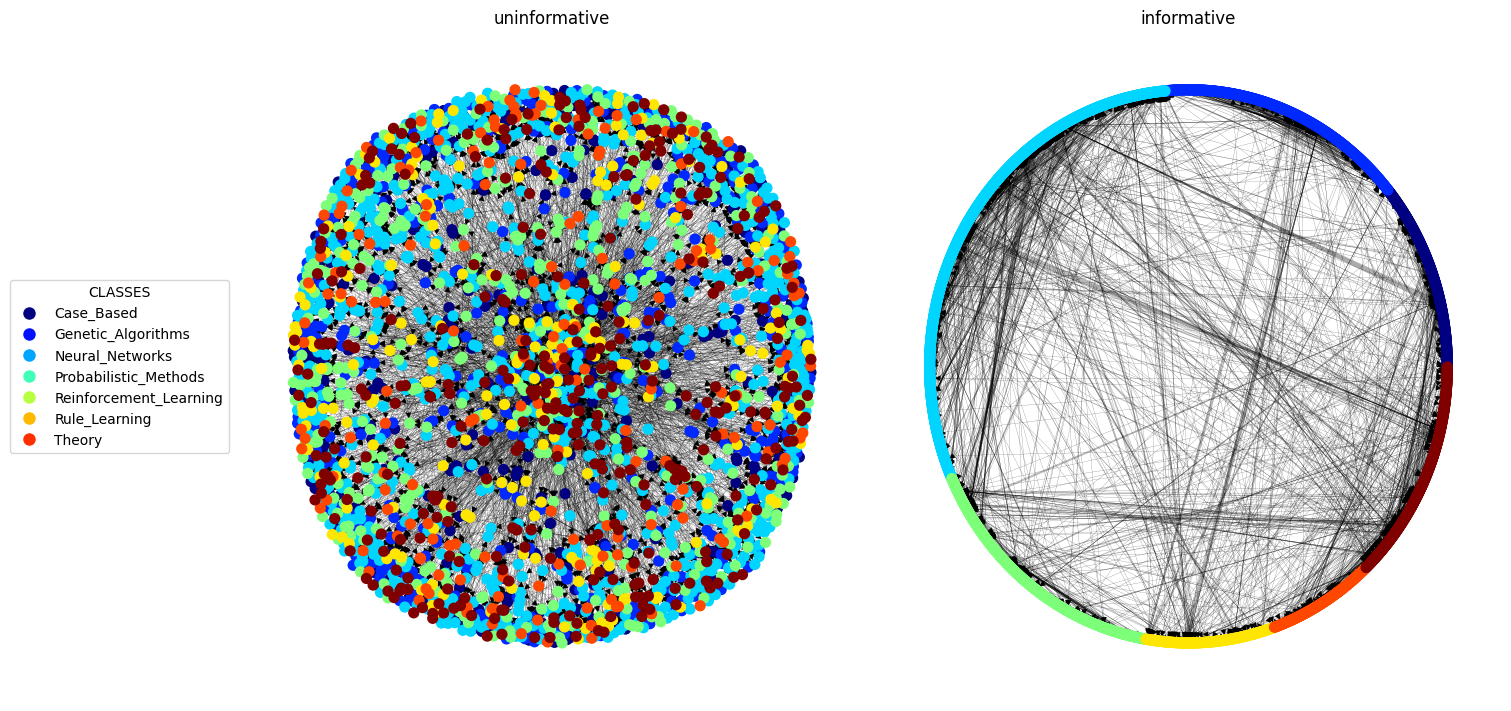

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

# read citation and publication class data
df_cites = pd.read_csv("hw4-cora.cites", names=["cited", "cites"], sep="\t")
df_content = pd.read_csv(
    "hw4-cora.content", usecols=[0, 1434], names=["id", "class"], sep="\t", index_col="id"
)["class"]

# build the directed graph and set the "class" attribute
G = nx.from_pandas_edgelist(df_cites, source="cited", target="cites", create_using=nx.DiGraph())
nx.set_node_attributes(G, df_content.to_dict(), "class")

print(f"Scientific publications:\t{G.number_of_nodes()}")
print(f"Citation network links:\t\t{G.number_of_edges()}")

# define a color map for classes and create a circular layout
unique_classes = sorted(df_content.unique())
color_map = {cls: idx for idx, cls in enumerate(unique_classes)}
sorted_nodes = sorted(G.nodes, key=lambda n: color_map[G.nodes[n]["class"]])
node_colors = [color_map[G.nodes[n]["class"]] for n in sorted_nodes]
angles = np.linspace(0, 2 * np.pi, len(sorted_nodes), endpoint=False)
pos = {node: (np.cos(angle), np.sin(angle)) for node, angle in zip(sorted_nodes, angles)}

# plot the network
# fmt: off
fig, axs = plt.subplots(ncols=3, figsize=(15, 7), layout="constrained",  gridspec_kw=dict(width_ratios=[0.5, 2, 2]))

legend_handles = [
    plt.Line2D([0], [0], marker="o", color="w",
               markerfacecolor=plt.cm.jet(color_map[cls] / len(unique_classes)),
               markersize=10)
    for cls in unique_classes
]
axs[0].legend(legend_handles, unique_classes, title="CLASSES", loc="center")
axs[0].axis("off")

axs[1].set_title("uninformative")
axs[2].set_title("informative")

nx.draw(G, nx.spring_layout(G), nodelist=sorted_nodes, node_color=node_colors, with_labels=False,
        node_size=50, width=0.1, cmap=plt.cm.jet, ax=axs[1])

nx.draw(G, pos, nodelist=sorted_nodes, node_color=node_colors, with_labels=False,
        node_size=50, width=0.1, cmap=plt.cm.jet, ax=axs[2])

##### 3. Generating Barbasi-Albert Networks

(b) The Barabasi-Albert model theoretically has a power-law degree distribution, with $\lambda = 3$. In the example below, the smallest network ($10^2$ nodes) shows considerable finite sample fluctuations and its degree distribution is noisy. As the network size increases ($10^3$, $10^4$ nodes), the distributions become smoother and converges to the expected power-law form, where $\hat\lambda \overset{p}{\to} 3$.

(e) Node degree increase over time, where nodes added early increase their degrees at a faster rate than nodes added later. This example demonstrates how BA models give rise to scale-free properties - the combination of the *growth* of the network through the addition of new nodes and *preferential attachment*, where new nodes prefer to link to already well-connected nodes.

Text(0, 0.5, '$\\log{C}$')

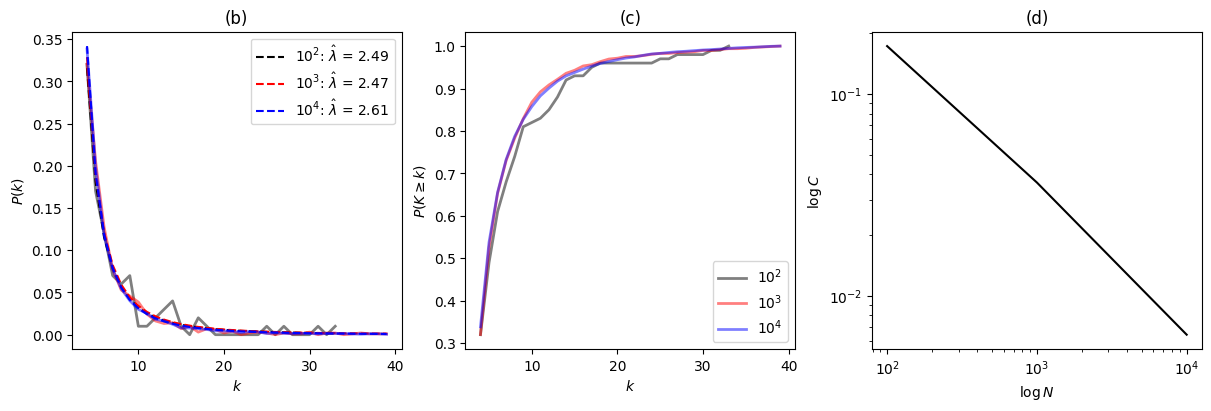

In [2]:
from scipy.optimize import curve_fit

# (a) calculate the degree distribution at 10^2, 10^3, and 10^4 nodes
n_nodes = [10**2, 10**3, 10**4]
degree_dists, clustering_coeffs = [], []
for n in n_nodes:
    G = nx.barabasi_albert_graph(n=n, m=4, seed=25)
    degree_dists.append(nx.degree_histogram(G))
    clustering_coeffs.append(nx.average_clustering(G))

# (b) plot degree distributions and fit a power-law
# (c) plot the cumulative degree distribution
fig, axs = plt.subplots(ncols=3, figsize=(12, 4), layout="constrained")
for dist, n, c in zip(degree_dists, ["10^2", "10^3", "10^4"], ["k", "r", "b"]):
    dist = np.asarray(dist)[4:40]  # drop initial zeros
    prob = dist / dist.sum()

    # fit power law by nls
    def power_law(k, a, lamb):
        return a * k ** (-lamb)

    ks = np.arange(4, 4 + len(prob))
    params_, _ = curve_fit(f=power_law, xdata=ks, ydata=prob)

    # degree + power law fits
    # fmt: off
    axs[0].plot(ks, prob, color=c, lw=2, alpha=0.5)
    axs[0].plot(ks, power_law(ks, *params_), "--", color=c, label=f"${n}$: " + r"$\hat\lambda$ = " + f"{params_[1]:.2f}")

    # cumulative dist
    axs[1].plot(ks, np.cumsum(prob), '-', color=c, lw=2, alpha=0.5, label=f"${n}$")


axs[0].set_title("(b)")
axs[0].set_xlabel("$k$")
axs[0].set_ylabel("$P(k)$")
axs[0].legend()

axs[1].set_title("(c)")
axs[1].set_xlabel("$k$")
axs[1].set_ylabel("$P(K\\geq k)$")
axs[1].legend()

axs[2].set_title("(d)")
axs[2].loglog(n_nodes, clustering_coeffs, c="k")
axs[2].set_xlabel(r"$\log{N}$")
axs[2].set_ylabel(r"$\log{C}$")

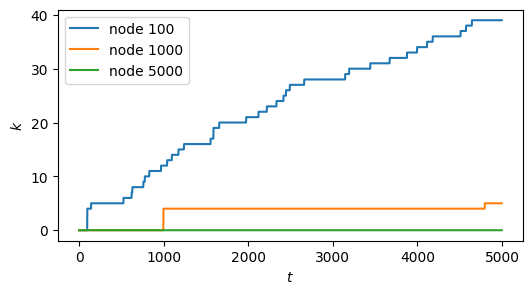

In [3]:
# (e) plot degree dynamics vs time
n, m = 10**4, 4
ts = [100, 1000, 5000]
deg_hist = {n: [] for n in ts}

G = nx.complete_graph(m)  # for intermediate steps
for n in ts:
    deg_hist[n].append(G.degree(n) if n in G else 0)

for t in range(m, n):
    rep = [node for node in G.nodes() for _ in range(G.degree(node))]
    targets = set()
    while len(targets) < m:
        targets.add(random.choice(rep))
    G.add_node(t)
    G.add_edges_from((t, target) for target in targets)
    for n in ts:
        deg_hist[n].append(G.degree(n) if n in G else 0)

fig, ax = plt.subplots(figsize=(6, 3))
for n in ts:
    ax.plot(deg_hist[n], label=f"node {n}")

ax.set_xlabel("$t$")
ax.set_ylabel("$k$")
ax.legend()

##### 4. Modifying the Barabasi-Albert Model

(a) To reach a final network size of $N=10^4$, the simulation needs to run for an additional $1000$ timesteps to compensate for deleting a node every $10^{\text{th}}$ timestep. Removing nodes at random alightly interrupts the "rich-get-richer" dynamic of  preferential attachment, such that the average degree is higher than the original model because hubs struggle to form. This more homogeneous structure is difficult to detect visually, likely because the rate of node deletion is relatively low. Likewise, the degree distribution still maintains a power law structure.

(b) Deleting $2m$ links every $10^th$ step has a large effect on the graph structure. The effects are similar to (a) but there are individual nodes that get completely disconnected from the network. The connected components, however, still seem to follow a power law distribution. This is because the scale-free property means that the graph looks similar regardless of its scale. 

(c) This modification produces a network that globally looks similar to (a) but the degree and hub structures are much different. The absence of preferential attachment means that nodes are equally likely to link to any other node, regardless of degree. The degree appears exponential (rather than power law), meaning that the network lacks hubs. 

(d) For each timestep, new nodes are added following preferential attachment. Additionally, every 20th step an extra edge is added betweem two randomly selected nodes (to model occasional random clustering). The appearance of the network is almost indistinguishable from (a) because new nodes still follow preferential attachment, while the addition of random edges reduces the prominence of hubs, but only moderately. Reducing the hubs reduces the average degree, but the distribution of degrees still looks like power law.

Experiment: (3) Original BA
Final number of nodes: 10000
Final number of edges: 39990


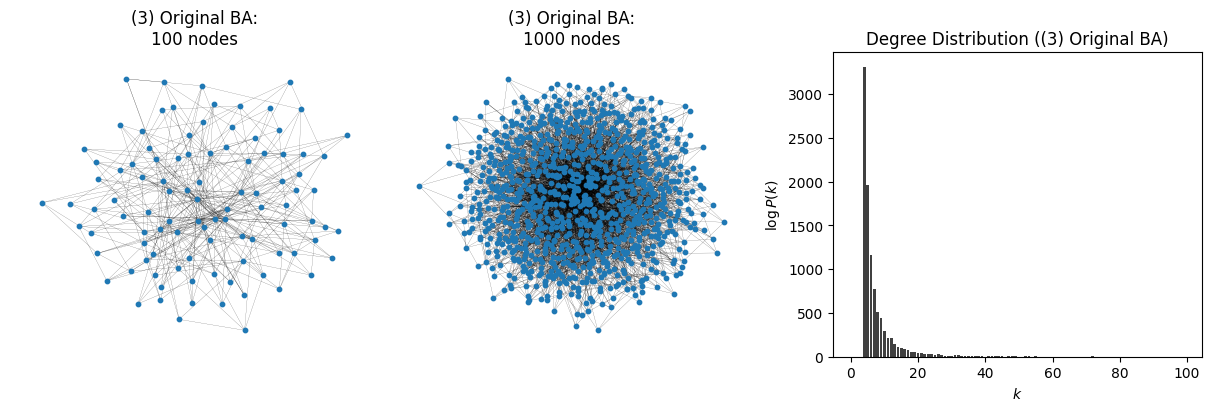

Experiment: (a) BA with Node Deletion
Final number of nodes: 16002
Final number of edges: 57445


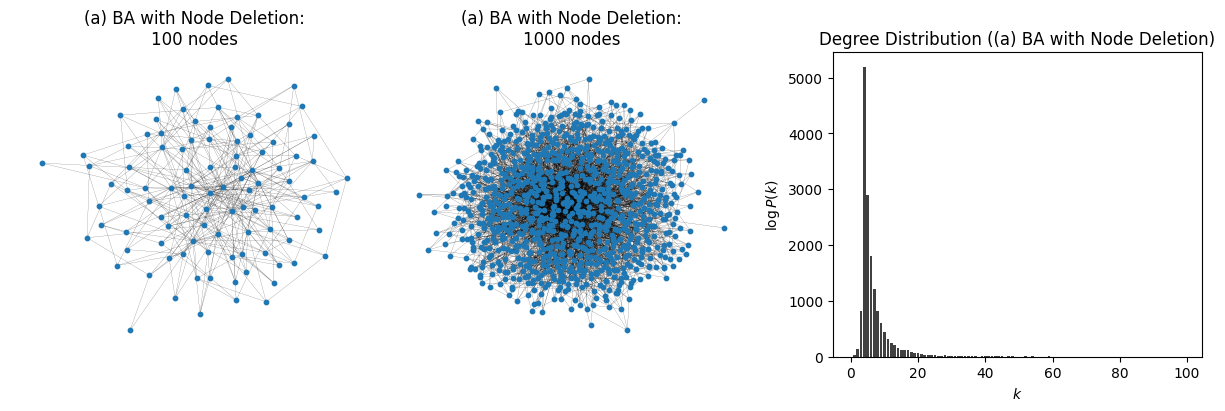

Experiment: (b) BA with Edge Deletion
Final number of nodes: 18001
Final number of edges: 56002


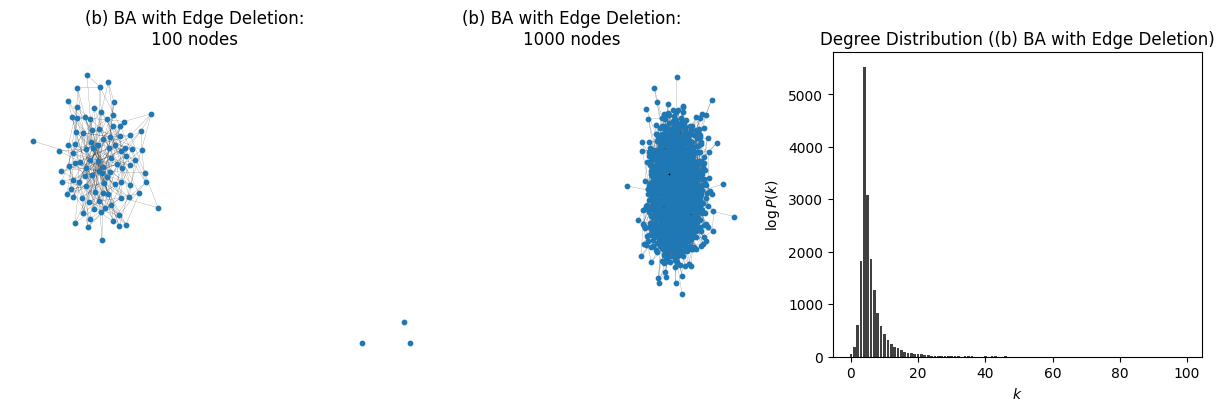

Experiment: (c) Uniform Attachment
Final number of nodes: 10000
Final number of edges: 39990


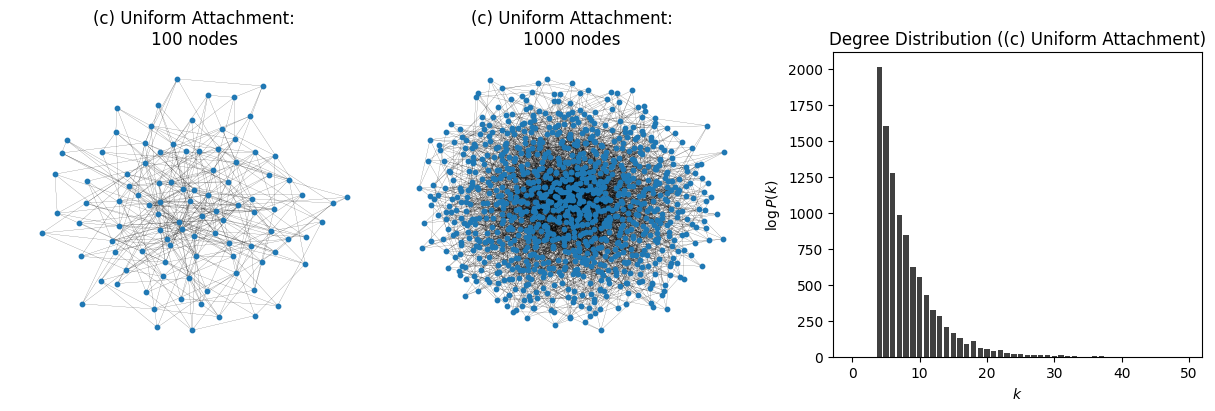

Experiment: (d) Hybrid Attachment
Final number of nodes: 10000
Final number of edges: 40489


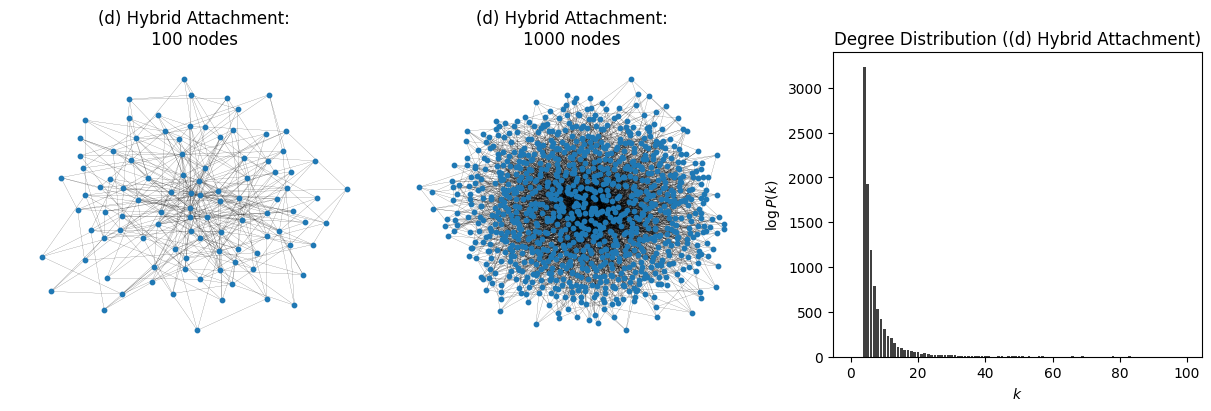

In [4]:
def simulate_experiment(exp_type, total_steps, m_edges):
    # start with a complete graph of m_edges nodes.
    G = nx.complete_graph(m_edges)
    snapshots = {}
    snapshot_targets = sorted([100, 1000])
    next_snapshot = snapshot_targets.pop(0) if snapshot_targets else None

    for t in range(m_edges, total_steps):
        # capture network snapshots when node count first reaches the target
        if next_snapshot is not None and G.number_of_nodes() >= next_snapshot:
            snapshots[next_snapshot] = G.copy()
            next_snapshot = snapshot_targets.pop(0) if snapshot_targets else None

        if exp_type == "original":  # (3)
            # standard preferential attachment
            rep = [node for node in G for _ in range(G.degree(node))]
            targets = set()
            while len(targets) < min(m_edges, len(G)):
                targets.add(random.choice(rep))
            G.add_node(t)
            for target in targets:
                G.add_edge(t, target)
        elif exp_type == "delete_node":  # (a)
            if t % 10 == 0 and len(G) > 0:
                # every 10th time, delete a random node.
                node_to_remove = random.choice(list(G.nodes()))
                G.remove_node(node_to_remove)
            else:
                rep = [node for node in G for _ in range(G.degree(node))]
                targets = set()
                while len(targets) < min(m_edges, len(G)):
                    targets.add(random.choice(rep))
                G.add_node(t)
                for target in targets:
                    G.add_edge(t, target)
        elif exp_type == "delete_edges":  # (b)
            if t % 10 == 0 and G.number_of_edges() > 0:
                # every 10th time, remove 2*m_edges random edges.
                edges = list(G.edges())
                num_edges_to_delete = min(2 * m_edges, len(edges))
                edges_to_remove = random.sample(edges, num_edges_to_delete)
                G.remove_edges_from(edges_to_remove)
            else:
                rep = [node for node in G for _ in range(G.degree(node))]
                targets = set()
                while len(targets) < min(m_edges, len(G)):
                    targets.add(random.choice(rep))
                G.add_node(t)
                for target in targets:
                    G.add_edge(t, target)
        elif exp_type == "uniform":  # (c)
            # growth without preferential attachment (choose targets uniformly)
            nodes = list(G.nodes())
            targets = set()
            while len(targets) < min(m_edges, len(G)):
                targets.add(random.choice(nodes))
            G.add_node(t)
            for target in targets:
                G.add_edge(t, target)
        elif exp_type == "hybrid":  # New experiment
            # Standard preferential attachment first.
            rep = [node for node in G for _ in range(G.degree(node))]
            targets = set()
            while len(targets) < min(m_edges, len(G)):
                targets.add(random.choice(rep))
            G.add_node(t)
            for target in targets:
                G.add_edge(t, target)
            # Every 20th time step add an extra random edge between two nodes that are not connected.
            if t % 20 == 0:
                nodes = list(G.nodes())
                attempts = 0
                while attempts < 100:  # try a few times to find a non-existing edge
                    node1, node2 = random.sample(nodes, 2)
                    if not G.has_edge(node1, node2):
                        G.add_edge(node1, node2)
                        break
                    attempts += 1
        else:
            raise ValueError("Unknown experiment type")

    return G, snapshots


def plot_network_snapshots(snapshots, experiment_name, axs):
    for i, snapshot_key in enumerate(sorted(snapshots.keys())):
        # use spring layout for visualization.
        pos = nx.spring_layout(snapshots[snapshot_key])
        nx.draw(snapshots[snapshot_key], pos, node_size=10, width=0.1, with_labels=False, ax=axs[i])
        axs[i].set_title(f"{experiment_name}:\n{snapshot_key} nodes")


def plot_degree_distribution(G, experiment_name, ax):
    hist = nx.degree_histogram(G)[:100]
    degrees = np.arange(len(hist))
    ax.bar(degrees, hist, color="k", alpha=0.75)
    ax.set_xlabel("$k$")
    ax.set_ylabel(r"$\log{P(k)}$")
    ax.set_title(f"Degree Distribution ({experiment_name})")


experiment_types = {
    "(3) Original BA": "original",
    "(a) BA with Node Deletion": "delete_node",
    "(b) BA with Edge Deletion": "delete_edges",
    "(c) Uniform Attachment": "uniform",
    "(d) Hybrid Attachment": "hybrid",  # New experiment
}

for exp_name, exp_type in experiment_types.items():
    # increase size for deletion experiments
    total_steps = 2 * (10**4) if exp_type in ["delete_node", "delete_edges"] else 10**4
    G_exp, snapshots_exp = simulate_experiment(exp_type, total_steps, m_edges=4)

    print(f"Experiment: {exp_name}")
    print("Final number of nodes:", G_exp.number_of_nodes())
    print("Final number of edges:", G_exp.number_of_edges())

    fig, axs = plt.subplots(ncols=3, figsize=(12, 4), layout="constrained")
    plot_network_snapshots(snapshots_exp, exp_name, axs[:2])
    plot_degree_distribution(G_exp, exp_name, axs[2])
    plt.show()